# Graph Coloring

This page explains how to solve the graph coloring problem using Amplify


## Formulation of graph coloring problem


The graph coloring problem is a problem of assigning colors to the vertices of a certain graph under given constraints. The most typical problem is to color a graph so that the adjacent vertices have different colors.

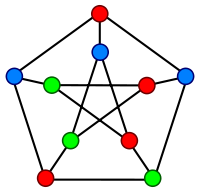

In a plane graph (map), the `four color theorem <https://en.wikipedia.org/wiki/Four_color_theorem>`_ states that four colors are enough to color any map so that all adjacent regions in the map have distinct colors. However, it is not obvious how to implement such coloring.

Several application examples are known for the graph coloring problem, such as scheduling problems related to allocation of conference rooms, machines, tasks, etc., register allocation by a compiler, frequency allocation in a mobile phone network. Here, we demonstrate a way to solve a graph coloring problem using an Ising machine by coloring the prefectures in Japan.

In order to use Ising machines, we consider how to express the states of the coloring of the graph in terms of binary variables. It can be expressed by assigning $0$ or $1$ to each region using four variables as follows:

| Region | Red | Green | Blue | Yellow |
|--------|-----|-------|------|--------|
| 1      | 0   | 0     | 1    | 0      |
| 2      | 0   | 1     | 0    | 0      |
| 3      | 0   | 0     | 1    | 0      |
| 4      | 1   | 0     | 0    | 0      |

    
This example means assigning blue to region $1$, green to region $2$, blue to region $3$, and red to region $4$. We will represent each variable in the above table as $q_{i,c}$ using the region index $i$ and the color index $c$. Therefore, the number of variables required is $NC$ for the number of regions $N$ and the number of colors $C$.

The following constraints are imposed on the variables accordingly to the definition of the coloring problem.

* Paint one region with one color
* Adjacent regions must have distinct colors

When these are formulated, they are expressed as follows:

**Constraints**

$$
\begin{align}
    \sum_{c = 0}^{C-1}{ q_{i,c} } = 1 & \quad \text{for all} \; i \\
    q_{i,c} q_{j,c} = 0 & \quad \text{if Region} \; i \; \text{and Region} \; j \; \text{are adjacent}
\end{align}
$$

Here, $E$ represents a set of pairs of adjacent regions on the graph. Please note that the variable index starts at $0$ for the convenience of later program coding.


## Creating a problem

We use Python's [japanmap](https://pypi.org/project/japanmap/) module to work with maps of Japan. You can get the prefecture name, adjacency information, etc. using the prefecture code ($1$-$47$).

First, we define the colors and prepare the variable table. To match the prefecture code with the index in the program code, prepare a dummy prefecture and create $(47 + 1) \times 4$ binary variables.

In [ ]:
from amplify import VariableGenerator
import japanmap as jm

colors = ["red", "green", "blue", "yellow"]
num_colors = len(colors)
num_region = len(jm.pref_names)  # Obtain the number of prefectures

gen = VariableGenerator()
q = gen.array("Binary", shape=(num_region, num_colors))

Next, we create constraint conditions. The one-hot constraints can be written using the `amplify.one_hot` function, and constraints with a minimum value of 0 can be written using the `amplify.equal_to` function as follows.


In [ ]:
from amplify import sum as amplify_sum, one_hot, equal_to


# Constraints on each region
reg_constraints = one_hot(q[1:], axis=1)  # excluding the dummy prefecture


# Constraints between adjacent regions
adj_constraints = amplify_sum(
    equal_to(q[i, :] * q[j, :], 0, axis=())
    for i in range(1, num_region)
    for j in jm.adjacent(i)  # j: the prefecture code adjacent to the prefecture i
    if i < j  # type: ignore
)

model = reg_constraints + adj_constraints

Adjacent information can be obtained by entering the state code in the `japanmap.adjacent` function.


## Ising machine execution

We create a solver client for the Ising machine and set the parameters. We then solve the fomulated problem.

In [ ]:
from amplify import AmplifyAEClient, solve
from datetime import timedelta

client = AmplifyAEClient()
client.parameters.time_limit_ms = timedelta(milliseconds=1000)  # timeout is 1000 ms
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # If you use Amplify in a local environment or Google Colaboratory, enter your Amplify API token.

# Solve the problem
result = solve(model, client)
if len(result) == 0:
    raise RuntimeError("Some constraints are unsatisfied.")

### Note

If the ``result`` object is empty, no solution that satisfies the constraint condition was obtained. In this case, it is necessary to change the parameters of the Ising machine.

## Analysis of the results

We decode the solution into the same format as the variable table `q` as follows. The first column of `q` is for the dummy prefecture, and its value is unimportant.

In [ ]:
q_values = q.evaluate(result.best.values)

q_values

We convert the result to a dictionary with ``{prefecture name: color}`` format. First, we obtain the index with the value of 1 in each row of ``q_values``, by using a numpy function as shown below. After that, `japanmap.pref_names` is used to convert the row indices to prefecture names, and we create the dictionary by pairing them with the corresponding colors.

In [ ]:
import numpy as np

color_indices = (q_values[1:] @ np.arange(num_colors)).astype(
    int
)  # the first row of q_values is for the dummy prefecture and not needed.
color_map = {
    jm.pref_names[region_idx]: colors[color_idx]
    for region_idx, color_idx in enumerate(
        color_indices, start=1
    )  # Note that region_idx starts from 1
}

In [ ]:
color_map

Lastly we display the colored map. It is plotted as follows:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 6, 6
plt.imshow(jm.picture(color_map))
plt.show()